# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [7]:
def ddpg(agent, n_episodes=100, max_t=10000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    average_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        moving_avgs = []                               # list of moving averages
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        average_scores.append(np.mean(scores))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_scores[-1]), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_scores[-1]))
            print('Moving Average Score: {}'.format(moving_average(average_scores, n=print_every)[-1]))
            
    return average_scores

In [8]:
def plotscores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    ma = moving_average(scores, n=100)
    plt.plot(np.arange(1, len(ma)+1), ma)
    plt.ylabel('Moving Average Score')
    plt.xlabel('Episode #')
    plt.show()

In [9]:
_BUFFER_SIZE = int(1e6)  # replay buffer size
_BATCH_SIZE = 256        # minibatch size
_GAMMA = 0.995            # discount factor
_TAU = 1e-3              # for soft update of target parameters
_LR_ACTOR = 1e-4         # learning rate of the actor 
_LR_CRITIC = 1e-4        # learning rate of the critic
_WEIGHT_DECAY = 0        # L2 weight decay
_mu=0.                   # Ornstein-Uhlenbeck noise parameters
_theta=0.15              # Ornstein-Uhlenbeck noise parameters
_sigma=0.1               # Ornstein-Uhlenbeck noise parameters
_actor_fc1_units=64
_actor_fc2_units=32
_critic_fc1_units=64
_critic_fc2_units=32

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2,
    BUFFER_SIZE = _BUFFER_SIZE,  # replay buffer size
    BATCH_SIZE = _BATCH_SIZE,        # minibatch size
    GAMMA = _GAMMA,            # discount factor
    TAU = _TAU,              # for soft update of target parameters
    LR_ACTOR = _LR_ACTOR,         # learning rate of the actor 
    LR_CRITIC = _LR_CRITIC,        # learning rate of the critic
    WEIGHT_DECAY = _WEIGHT_DECAY,       # L2 weight decay
    mu = _mu,
    theta= _theta,
    sigma= _sigma)

In [11]:
scores = ddpg(agent, 3000)

Episode 100	Average Score: -0.00
Moving Average Score: -0.0029999998584389685
Episode 200	Average Score: 0.100
Moving Average Score: -0.0034999998658895495
Episode 300	Average Score: -0.00
Moving Average Score: 0.0005000001937150955
Episode 400	Average Score: -0.00
Moving Average Score: -0.0029999998584389685
Episode 500	Average Score: -0.00
Moving Average Score: 0.006500000283122063
Episode 600	Average Score: 0.050
Moving Average Score: 0.007500000298023224
Episode 700	Average Score: -0.00
Moving Average Score: 0.010000000335276127
Episode 800	Average Score: -0.00
Moving Average Score: 0.005000000260770321
Episode 900	Average Score: 0.050
Moving Average Score: 0.008000000305473804
Episode 1000	Average Score: 0.05
Moving Average Score: 0.02050000049173832
Episode 1100	Average Score: 0.050
Moving Average Score: 0.027000000588595866
Episode 1200	Average Score: 0.050
Moving Average Score: 0.03150000065565109
Episode 1300	Average Score: 0.050
Moving Average Score: 0.034500000700354576
Epis

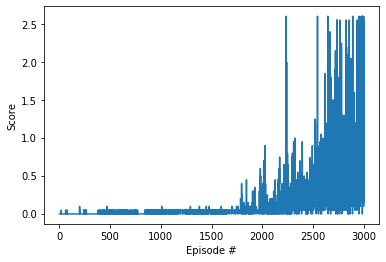

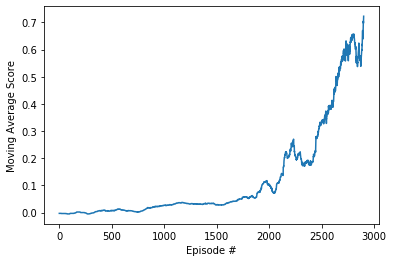

In [12]:
plotscores(scores)

In [13]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))


Total score (averaged over agents) this episode: 0.09500000160187483


When finished, you can close the environment.

In [14]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```